In [45]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



 Read Data


In [2]:
def reload():
    gc.collect()
    df = pd.read_csv('C:\\Users\\ymo\\Desktop\\502FP\\train_V2.csv')
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
    df = df[-df['matchId'].isin(invalid_match_ids)]
    return df

#df = reload()

 # 1.Check correlation of feature
This is the simplest way to see the relation between features

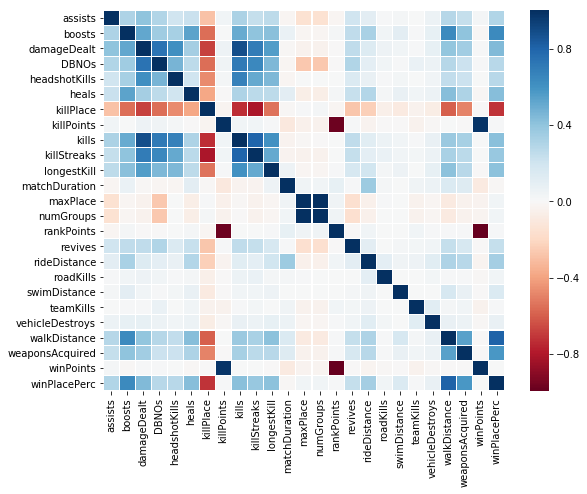

In [3]:
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()



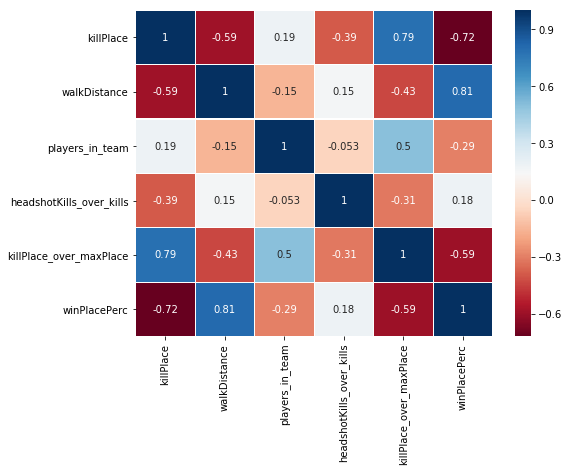

In [4]:
agg = df.groupby(['groupId']).size().to_frame('players_in_team')
df = df.merge(agg, how='left', on=['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
corr = df[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

# 2.  a simple model to exam different combination of features

I used LinearRegression during feature engineering since it's simple and fast. It'd be enough if you just want to see the impact of the new feature you added.


* Prepare for cross validation

* validation set


In [8]:
def train_test_split(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def run_experiment(preprocess):
    
    df = reload()
    df = preprocess(df)

    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target,'matchType']
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    #cols_to_fit=[col for col in df.columns if col[-4:]=='rank']
    #train, val = train_test_split(df, 0.1)
    

    model = LinearRegression()
    #model.fit(train[cols_to_fit], train[target])

    #y_true = val[target]
    #y_pred = model.predict(val[cols_to_fit])
    scores = cross_val_score(model, df[cols_to_fit], df[target], cv=5, scoring='neg_mean_absolute_error')
    return str(scores.mean())[1:9] + '+/-' + str(scores.std()*2)[0:9]

def run_experiments(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time = time.time() - start
        results.append({
            'name': preprocess.__name__,
            'score': score,
            'execution time': f'{round(execution_time, 2)}s'
        })
        gc.collect()
        
    return pd.DataFrame(results, columns=['name', 'score', 'execution time']).sort_values(by='score')

# 3. some new features


In [150]:
def original(df):
    return df

def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how='left', on=['groupId'])

def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

def headshotKills_over_kills(df):
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace=True)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc','matchType']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])


* expriment with some new features

In [18]:
run_experiments([
    original,
    items,
    players_in_team,
    total_distance,
    headshotKills_over_kills,
    killPlace_over_maxPlace,
    walkDistance_over_heals,
    walkDistance_over_kills,
    teamwork
])

,name,score,execution time
2,players_in_team,0.091705,50.43s
4,headshotKills_over_kills,0.091903,32.82s
0,original,0.092054,36.88s
7,walkDistance_over_kills,0.092315,33.5s
3,total_distance,0.092535,34.51s
5,killPlace_over_maxPlace,0.092709,36.16s
6,walkDistance_over_heals,0.092876,35.89s
1,items,0.093002,35.32s
8,teamwork,0.093496,34.53s


* group by experiment

In [15]:
run_experiments([
    original,
    min_by_team,
    max_by_team,
    sum_by_team,
    median_by_team,
    mean_by_team,
    rank_by_team
])

,name,score,execution time
6,rank_by_team,0.057353,90.64s
4,median_by_team,0.076205,77.99s
5,mean_by_team,0.076749,79.19s
2,max_by_team,0.078941,86.41s
3,sum_by_team,0.088363,88.54s
1,min_by_team,0.089599,86.18s
0,original,0.092412,36.77s


### As you can see,  group by teams import our result a lot, next we want to try some more complicated algorithms

In [40]:
run_experiments([
    original,
    items])

,name,score,execution time
0,original,-0.092+/-0.0001,52.94s
1,items,-0.092+/-0.0001,49.67s


In [41]:
run_experiments([
    sum_by_team,
    mean_by_team,
    rank_by_team])

,name,score,execution time
2,rank_by_team,-0.057+/-0.0001,158.41s
1,mean_by_team,-0.077+/-0.0001,140.4s
0,sum_by_team,-0.088+/-0.0001,150.16s


### PCA on rank_by_team+ scale + median+ linear reg, result is not bad

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
def pca_with_9(df):
    df=rank_and_median(df)
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target,'matchType']
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    #cols_to_fit=[col for col in df.columns if col[-4:]=='rank']
    pca = PCA(n_components=7)
    df_scale=scale(df[cols_to_fit])
    pca.fit(df_scale)
    singular_value=pca.singular_values_
    singular_value.sort()
    plt.plot(singular_value)
    return pca.transform(df_scale)

In [28]:
def run_experiment(df,target):
    model = LinearRegression()
    scores = cross_val_score(model, df, target, cv=5, scoring='neg_mean_absolute_error')
    return str(scores.mean())[1:9] + '+/-' + str(scores.std()*2)[0:9]

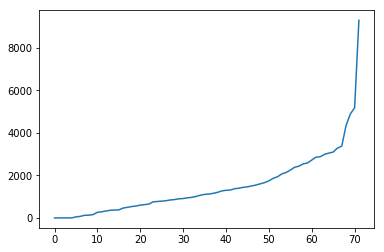

In [6]:
x_scale=pca_with_9(reload())

In [ ]:
df_raw=reload()

In [17]:
run_experiment(x_scale,df_raw['winPlacePerc'])

'0.056602+/-0.0001083'

### PCA with out scale + rank_by_team is worse than linear

In [ ]:
def pca_with_8(df):
    df=rank_by_team(df)
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target,'matchType']
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    #cols_to_fit=[col for col in df.columns if col[-4:]=='rank']
    pca = PCA(n_components=8
    pca.fit(df[cols_to_fit])
    singular_value=pca.singular_values_
    singular_value.sort()
    plt.plot(singular_value)
    return pca.transform(df[cols_to_fit])

'0.129707+/-0.0001495'

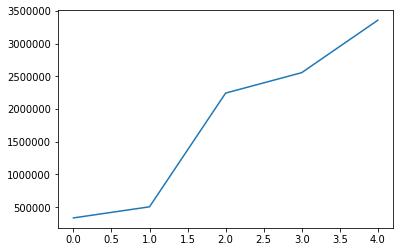

In [18]:
run_experiment(
pca_with_8)

## pca on only rank features result is better than last step

In [21]:
df=reload()
df.drop(columns=['matchType'], inplace=True)
df=rank_by_team(df)

In [28]:
cols_to_fit=[col for col in df.columns if col[-4:]=='rank']

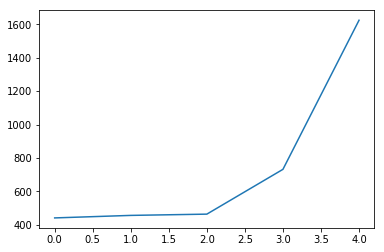

In [31]:
def pca_with_6(df):
    cols_to_fit=[col for col in df.columns if col[-4:]=='rank']
    pca = PCA(n_components=2)
    pca.fit(df[cols_to_fit])
    singular_value=pca.singular_values_
    singular_value.sort()
    plt.plot(singular_value)
    return pca.transform(df[cols_to_fit])
pca_rank_array=pca_with_6(df_raw)

#### import data

In [91]:
df_raw=reload()
#df_raw.drop(columns=['matchType'], inplace=True)

# pca on originl team_by_mean 

'0.118084+/-0.0001848'

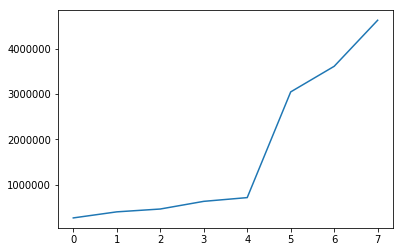

In [36]:
df_raw.drop(columns=['matchType'], inplace=True)
def pca_with_2(df):
    df=mean_by_team(df)
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId',, target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    pca = PCA(n_components=8)
    pca.fit(df[cols_to_fit])
    singular_value=pca.singular_values_
    singular_value.sort()
    plt.plot(singular_value)
    return pca.transform(df[cols_to_fit])

pca_mean_by_team=pca_with_2(df_raw)
run_experiment(pca_mean_by_team,df_raw['winPlacePerc'])

## pca  clustering

In [9]:
from sklearn.decomposition import PCA, KernelPCA
def pca_with_6(df):
    cols_to_fit=[col for col in df.columns if col[-4:]=='rank']
    kpca = KernelPCA(n_components=2, fit_inverse_transform=True, gamma=10)
    df_kpca = kpca.fit_transform(df[cols_to_fit])
    singular_value=kpca.singular_values_
    singular_value.sort()
    plt.plot(singular_value)
    return df_kpca
#df_raw.drop(columns=['matchType'], inplace=True)
df_rank_team=rank_by_team(df_raw)
pca_rank_array=pca_with_6(df_rank_team)


MemoryError: 

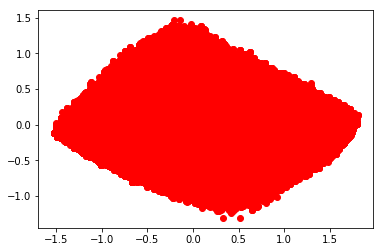

In [54]:
plt.plot(pca_rank_array[:,0],pca_rank_array[:,1],'ro')

### run experiment only with rank features results is a litte worse than run with all features
* #cols_to_fit=[col for col in df.columns if col[-4:]=='rank']

In [23]:
run_experiment(rank_by_team)

'0.117240+/-0.0001480'

### Random forest work better than linear reg

In [72]:
def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc','matchType']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])
 
def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc', 'matchType']
    features = [col for col in df.columns if col not in cols_to_drop and '_mean_rank' not in col]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def rank_and_median(df):
    df=rank_by_team(df)
    return median_by_team(df)

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
def run_experiment(preprocess):
    
    df = reload()
    
    
    df = preprocess(df)

    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target, 'matchType']
    #cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    cols_to_fit=[col for col in df.columns if col[-4:]=='rank']
    #train, val = train_test_split(df, 0.1)
    

    model = RandomForestRegressor(n_estimators=40,min_samples_leaf=10,max_features='sqrt',n_jobs=-1)

    #model.fit(train[cols_to_fit], train[target])

    #y_true = val[target]
    #y_pred = model.predict(val[cols_to_fit])
    scores = cross_val_score(model, df[cols_to_fit], df[target], cv=5, scoring='neg_mean_absolute_error')
    return str(scores.mean())[1:9] + '+/-' + str(scores.std()*2)[0:9]



In [51]:
run_experiment(rank_and_median)

'0.037831+/-8.2804164'

### another way of ranking not better

In [92]:
def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].apply(lambda x: x/x.max())
    return df.merge(agg, suffixes=['', '_rank'], how='left', on=['matchId', 'groupId']).fillna(0)
 


In [87]:
run_experiment(rank_by_team)

'0.045759+/-0.0001508'

##  scale all features

In [97]:
def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc','matchType']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].apply(lambda x: x/x.max())
    return scale(df.merge(agg, suffixes=['', '_rank'], how='left', on=['matchId', 'groupId']).fillna(0)[0:10000])
     
run_experiment(rank_by_team)

ValueError: could not convert string to float: 'squad-fpp'

### only on duo games    same with all games

In [138]:
# duo
def rank_by_team(df):
    df=df[(df_raw.numGroups <=50) & (df_raw.numGroups >25) ]
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc','matchType']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].apply(lambda x: x/x.max())
    return df.merge(agg, suffixes=['', '_rank'], how='left', on=['matchId', 'groupId']).fillna(0)
 


In [139]:
run_experiment(rank_by_team)

'0.045171+/-0.0001092'

### pca + random forest

In [24]:
def run_experiment():
    
    

    model = RandomForestRegressor(n_estimators=40,min_samples_leaf=10,max_features='sqrt',n_jobs=-1)

    #model.fit(train[cols_to_fit], train[target])

    #y_true = val[target]
    #y_pred = model.predict(val[cols_to_fit])
    scores = cross_val_score(model, x_scale, df_raw['winPlacePerc'], cv=5, scoring='neg_mean_absolute_error')
    return str(scores.mean())[1:9] + '+/-' + str(scores.std()*2)[0:9]

In [25]:
run_experiment()

'0.060195+/-0.0004339'

### pca raw only data team_by_mean

In [30]:
def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc','matchType']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def pca_with_3(df):
    df=mean_by_team(df)
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target,'matchType']
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop and '_mean' in col]
    #cols_to_fit=[col for col in df.columns if col[-4:]=='rank']
    pca = PCA(n_components=5)
    df_scale=scale(df[cols_to_fit])
    pca.fit(df_scale)
    singular_value=pca.singular_values_
    singular_value.sort()
    plt.plot(singular_value)
    return pca.transform(df_scale)

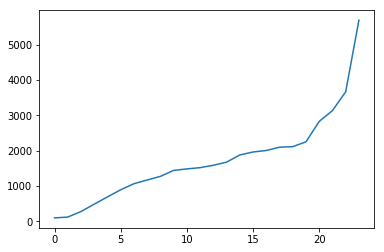

In [27]:
x_scale_3=pca_with_3(df_raw)

'0.129576+/-0.0001580'

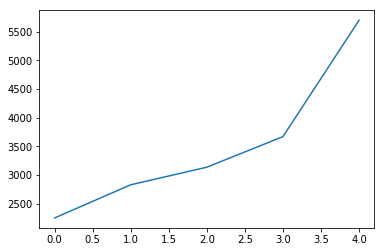

In [31]:
run_experiment(pca_with_3(df_raw),df_raw['winPlacePerc'])

### Worst model

In [34]:
pre_y_1=np.repeat(1,df_raw.shape[0])
mean_absolute_error(pre_y_1,df_raw['winPlacePerc'])

0.5271784472780875

## Lasso

In [37]:
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [64]:
def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc','matchType']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

df_raw=reload()
df_team_mean = mean_by_team(df_raw)



In [89]:
cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc','matchType']
features = [col for col in df_team_mean.columns if col not in cols_to_drop and '_mean' in col]
target='winPlacePerc'

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

(0.01, 1.0)

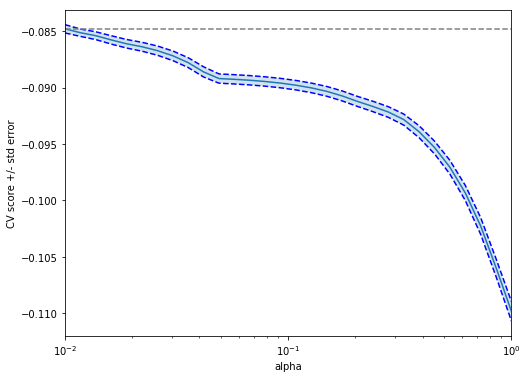

In [90]:
X = df_team_mean[features][0:10000]
y = df_team_mean[target][0:10000]

lasso = Lasso(random_state=0)
alphas = np.logspace(-2, 0, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, scoring='neg_mean_absolute_error')
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [70]:
X = df_team_mean[features][0:10000]
y = df_team_mean[target][0:10000]

reg = LassoCV(cv=5, random_state=0).fit(X, y)
print(reg.score(X, y) )
pre_lasso=reg.predict(X)
mean_absolute_error(pre_lasso,y)

0.852584892569752


0.0922376513057256

In [71]:
print(reg.coef_)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -4.50812159e-03 -2.55757970e-05
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.62239346e-04
  0.00000000e+00  8.70800230e-04  6.28240298e-05  0.00000000e+00
  2.51141256e-05 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.60598242e-04  0.00000000e+00  8.16554357e-05]


In [73]:
df_rank = rank_by_team(df_raw)
features = [col for col in df_rank.columns if col not in cols_to_drop and '_rank' in col]

In [74]:
X = df_rank[features][0:10000]
y = df_rank[target][0:10000]

reg = LassoCV(cv=5, random_state=0).fit(X, y)
print(reg.score(X, y) )
pre_lasso=reg.predict(X)
mean_absolute_error(pre_lasso,y)

0.9304621541400737


0.059391354211582245

In [86]:
coef=zip(features ,reg.coef_ )

In [87]:
list(coef)

[('assists_mean_rank', 0.021550244747605904),
 ('boosts_mean_rank', 0.11855286206262271),
 ('damageDealt_mean_rank', 0.002763059815160282),
 ('DBNOs_mean_rank', 0.00554132628601345),
 ('headshotKills_mean_rank', 0.0014612828817224966),
 ('heals_mean_rank', 0.006120768858735223),
 ('killPlace_mean_rank', -0.6226890762619465),
 ('killPoints_mean_rank', -0.01490910261904831),
 ('kills_mean_rank', -0.14783434705507476),
 ('killStreaks_mean_rank', -0.21597414532365314),
 ('longestKill_mean_rank', 0.0),
 ('matchDuration_mean_rank', -0.0),
 ('maxPlace_mean_rank', -0.0),
 ('numGroups_mean_rank', -0.0),
 ('rankPoints_mean_rank', 0.017648078531688368),
 ('revives_mean_rank', 0.02005699502021844),
 ('rideDistance_mean_rank', 0.0655444374932507),
 ('roadKills_mean_rank', -0.0),
 ('swimDistance_mean_rank', 0.0),
 ('teamKills_mean_rank', -0.012726514972894206),
 ('vehicleDestroys_mean_rank', -0.0),
 ('walkDistance_mean_rank', 0.48842406966767477),
 ('weaponsAcquired_mean_rank', 0.051077746988435396)